<a href="https://colab.research.google.com/github/PolianaQueiroz/Master-Research-Lab/blob/main/Bi_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Replicando o artigo

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print("\n✅ Google Drive montado.")

Mounted at /content/drive

✅ Google Drive montado.


In [ ]:
# 1.Caregar a base de dados
try:
    # Seu caminho (mantive o mesmo que você enviou)
    caminho_arquivo = '/content/drive/MyDrive/Chantelle/multi_bateria.csv'

    # --- CORREÇÃO AQUI: Adicionei encoding='latin-1' ---
    df = pd.read_csv(caminho_arquivo, encoding='latin-1')

    # Limpeza rápida
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna()
    print(f"✅ Arquivo carregado com sucesso de: {caminho_arquivo}")
    print(f"Linhas carregadas: {len(df)}")

except FileNotFoundError:
    print("ERRO: Verifique se o caminho do arquivo no Google Drive está correto.")
except UnicodeDecodeError:
    # Se latin-1 não funcionar, tenta cp1252
    print("Tentando encoding alternativo...")
    try:
        df = pd.read_csv(caminho_arquivo, encoding='cp1252')
        print(f"✅ Arquivo carregado com sucesso (cp1252)!")
    except:
        print("ERRO CRÍTICO de codificação. O arquivo pode estar corrompido ou em formato desconhecido.")

✅ Arquivo carregado com sucesso de: /content/drive/MyDrive/Chantelle/multi_bateria.csv
Linhas carregadas: 2660


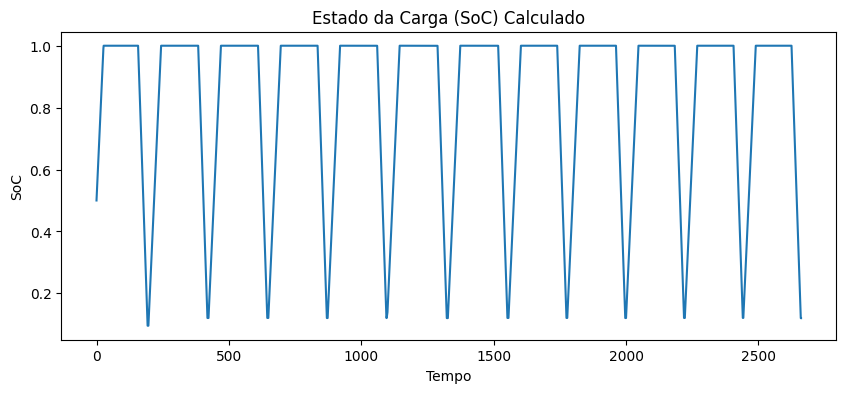

In [ ]:
#2. Engenharia de Recursos: Calcular o SoC (Target)
dt = 90  # 90 segundos
C_nom = 2.0 * 3600 # 2Ah em Coulombs
soc = [0.5] # SoC Inicial 50%

if 'df' in locals() and not df.empty:
    for i in df['I_measured'].values:
        new_soc = soc[-1] + (i * dt) / C_nom
        soc.append(np.clip(new_soc, 0, 1))

    df['SoC'] = soc[1:]

    # Visualizar
    plt.figure(figsize=(10, 4))
    plt.plot(df['SoC'])
    plt.title("Estado da Carga (SoC) Calculado")
    plt.xlabel("Tempo")
    plt.ylabel("SoC")
    plt.show()
else:
    print("O DataFrame está vazio. Verifique o carregamento.")

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler

# 1. Preparação dos Dados
print("Preparando dados...")
# Normalizar os dados para ficar entre 0 e 1 (ajuda a rede neural)
scaler = MinMaxScaler()
series = scaler.fit_transform(df['SoC'].values.reshape(-1, 1)).flatten()

# Divisão: 60% Treino, 20% Validação, 20% Teste (Conforme o artigo)
n = len(series)
train_size = int(n * 0.6)
val_size = int(n * 0.2)

train = series[:train_size]
val = series[train_size : train_size + val_size]
test = series[train_size + val_size :]

print(f"Dados divididos: {len(train)} treino, {len(val)} validação, {len(test)} teste")

# 2. Estágio Linear: ARIMA
print("\nTreinando ARIMA (pode demorar um pouquinho)...")
# ARIMA(5,1,0) é um bom ponto de partida para séries temporais
model_arima = ARIMA(train, order=(5,1,0)).fit()

# Gerar previsões (Base Line)
pred_linear_train = model_arima.predict(start=0, end=len(train)-1)
pred_linear_val = model_arima.predict(start=len(train), end=len(train)+len(val)-1)
pred_linear_test = model_arima.predict(start=len(train)+len(val), end=n-1)

# Calcular o ERRO do ARIMA (Resíduos)
# A IA vai aprender a prever esse erro para corrigir o modelo final
resid_train = train - pred_linear_train
resid_val_true = val - pred_linear_val

# --- 3. Estágio Não-Linear: Correção de Erro ---
print("\nTreinando modelos de correção de erro...")

# Função para criar "janelas" de tempo (Lags) para a entrada da IA
def create_lags(data, lags=3):
    X, y = [], []
    for i in range(len(data)-lags):
        X.append(data[i:i+lags])
        y.append(data[i+lags])
    return np.array(X), np.array(y)

lags = 3
# Cria dados de treino baseados apenas nos ERROS passados
X_train_res, y_train_res = create_lags(resid_train, lags)

# Pool de modelos candidatos (Árvore e Rede Neural)
pool_models = {
    'Decision Tree': DecisionTreeRegressor(max_depth=5),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(50,30), max_iter=500, random_state=42)
}

best_model = None
best_score = float('inf')
name_selected = ""

# Prepara validação
val_input_raw = np.concatenate([resid_train[-lags:], resid_val_true])
X_val_res, _ = create_lags(val_input_raw, lags)

# Seleção do melhor modelo (Competição)
for name, model in pool_models.items():
    model.fit(X_train_res, y_train_res)
    preds = model.predict(X_val_res)

    # Ajuste fino de tamanho
    min_len = min(len(resid_val_true), len(preds))
    score = mean_squared_error(resid_val_true[:min_len], preds[:min_len])

    print(f" > Modelo {name}: Erro (MSE) = {score:.6f}")

    if score < best_score:
        best_score = score
        best_model = model
        name_selected = name

print(f"\n Modelo Vencedor selecionado: {name_selected}")

Preparando dados...
Dados divididos: 1596 treino, 532 validação, 532 teste

Treinando ARIMA (pode demorar um pouquinho)...


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Treinando modelos de correção de erro...
 > Modelo Decision Tree: Erro (MSE) = 0.305317
 > Modelo Neural Network: Erro (MSE) = 0.322233

 Modelo Vencedor selecionado: Decision Tree


Sazonalidade

✅ Dados recarregados e limpos para análise de sazonalidade. Linhas: 2660
✅ SoC recalculado com sucesso.
✅ Timestamps e 'hour_of_day' gerados.


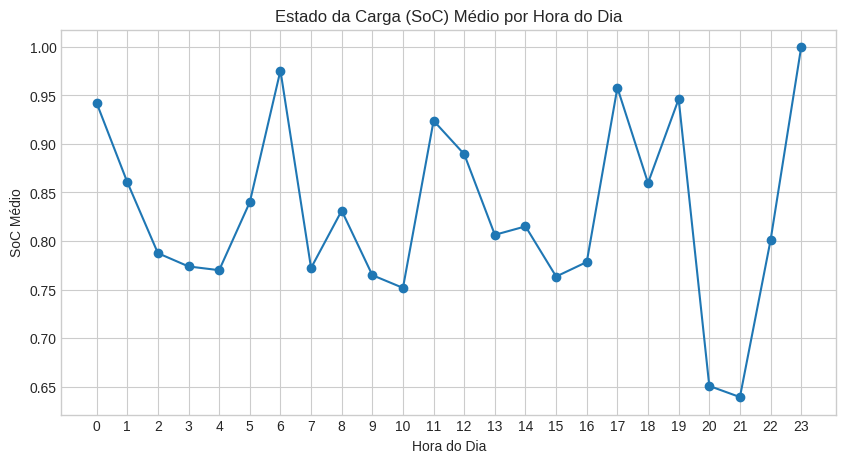

✅ Gráfico de sazonalidade horária do SoC gerado.


In [ ]:
import pandas as pd
import numpy as np # Needed for np.clip
import matplotlib.pyplot as plt

# --- 1. Load Data (similar to initial load) ---
caminho_arquivo = '/content/drive/MyDrive/Chantelle/multi_bateria.csv'
try:
    df_temp = pd.read_csv(caminho_arquivo, encoding='latin-1')
    # Initial cleaning
    for col in df_temp.columns:
        df_temp[col] = pd.to_numeric(df_temp[col], errors='coerce')
    df_temp = df_temp.dropna().reset_index(drop=True)
    print(f"✅ Dados recarregados e limpos para análise de sazonalidade. Linhas: {len(df_temp)}")

except FileNotFoundError:
    print("ERRO: Verifique se o caminho do arquivo no Google Drive está correto.")
    exit()
except Exception as e:
    print(f"ERRO ao carregar ou limpar os dados: {e}")
    exit()

# --- 2. Calculate SoC (similar to cell bLxj9UkeGF9c) ---
dt = 90  # 90 segundos (defined in bLxj9UkeGF9c)
C_nom = 2.0 * 3600 # 2Ah em Coulombs (defined in bLxj9UkeGF9c)
soc_values = [0.5] # SoC Inicial 50%

if 'I_measured' in df_temp.columns and not df_temp.empty:
    for i in df_temp['I_measured'].values:
        new_soc = soc_values[-1] + (i * dt) / C_nom
        soc_values.append(np.clip(new_soc, 0, 1))
    df_temp['SoC'] = soc_values[1:]
    print("✅ SoC recalculado com sucesso.")
else:
    print("❌ 'I_measured' não encontrado ou DataFrame vazio, não foi possível calcular o SoC.")
    exit()

# --- 3. Create Timestamp and Hour of Day (original logic from b5577213) ---
if 'Lag' in df_temp.columns and not df_temp.empty:
    start_time = pd.to_datetime('2023-01-01 00:00:00')
    time_delta = pd.to_timedelta(df_temp['Lag'] * dt, unit='s')
    df_temp['timestamp'] = start_time + time_delta
    df_temp['hour_of_day'] = df_temp['timestamp'].dt.hour
    print("✅ Timestamps e 'hour_of_day' gerados.")
else:
    print("❌ 'Lag' não encontrado ou DataFrame vazio, não foi possível gerar timestamps.")
    exit()

# --- 4. Calculate and Plot Hourly SoC ---
if 'SoC' in df_temp.columns and 'hour_of_day' in df_temp.columns and not df_temp.empty:
    hourly_soc = df_temp.groupby('hour_of_day')['SoC'].mean().reset_index()

    plt.figure(figsize=(10, 5))
    plt.plot(hourly_soc['hour_of_day'], hourly_soc['SoC'], marker='o')
    plt.title("Estado da Carga (SoC) Médio por Hora do Dia")
    plt.xlabel("Hora do Dia")
    plt.ylabel("SoC Médio")
    plt.xticks(range(24)) # Garante que todas as 24 horas são mostradas
    plt.grid(True)
    plt.show()
    print("✅ Gráfico de sazonalidade horária do SoC gerado.")
else:
    print("❌ Colunas 'SoC' ou 'hour_of_day' ausentes no DataFrame, ou DataFrame vazio. Não foi possível gerar o gráfico.")


Fazendo testes usando a variável de tensão no lugar da coluna que diz se a bateria está carrregada ou não

Treinando ARIMA na Tensão...


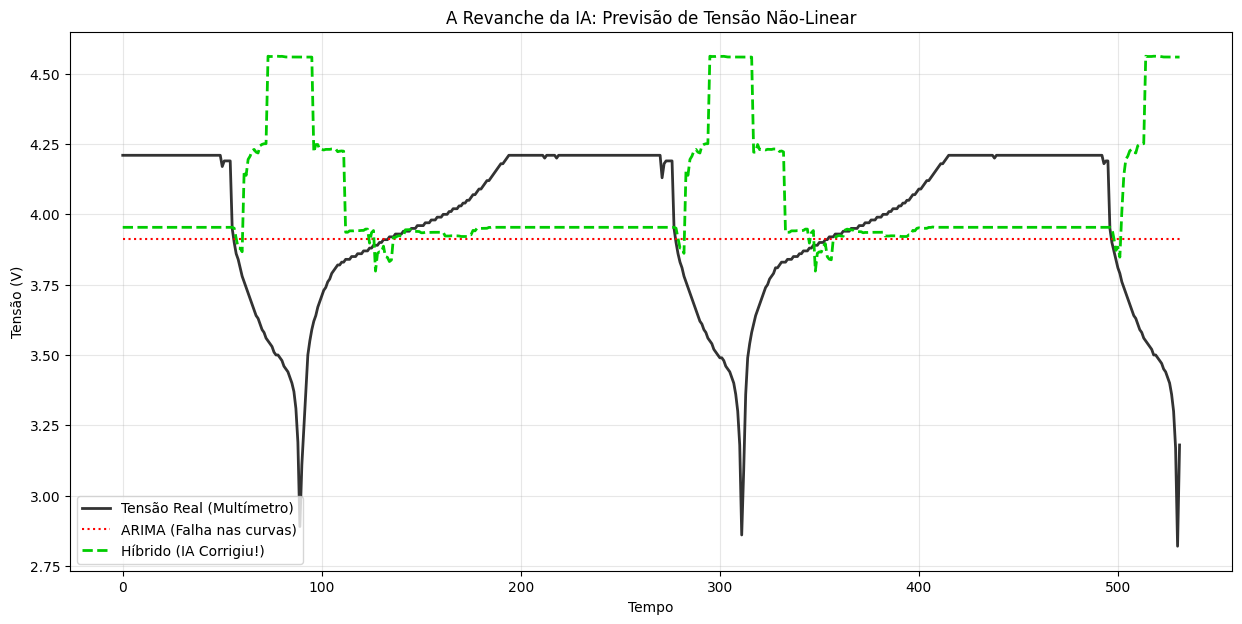

Erro ARIMA: 0.081341
Erro Híbrido: 0.227444
✅ MELHORIA: -179.62%


In [ ]:
# 1. Selecionar a Tensão como Alvo (em vez do SoC)
target_voltage = df['V_measured'].values.reshape(-1, 1)

# Normalizar
scaler_volts = MinMaxScaler()
series_volts = scaler_volts.fit_transform(target_voltage).flatten()

# Divisão (60/20/20)
n = len(series_volts)
train_v = series_volts[:int(n*0.6)]
val_v = series_volts[int(n*0.6):int(n*0.8)]
test_v = series_volts[int(n*0.8):]

# 2. Treinar ARIMA (O "Estatístico")
print("Treinando ARIMA na Tensão...")
model_arima_v = ARIMA(train_v, order=(5,1,0)).fit()

# Previsões Lineares
pred_L_train = model_arima_v.predict(start=0, end=len(train_v)-1)
pred_L_val = model_arima_v.predict(start=len(train_v), end=len(train_v)+len(val_v)-1)
pred_L_test = model_arima_v.predict(start=len(train_v)+len(val_v), end=n-1)

# Calcular o Erro que a IA precisa corrigir
resid_train_v = train_v - pred_L_train
resid_val_v = val_v - pred_L_val

# 3. Treinar Gradient Boosting (A "IA") nos Erros
from sklearn.ensemble import GradientBoostingRegressor

# Criar memória (Lags)
lags_v = 15
X_train_v, y_train_v = create_lags(resid_train_v, lags_v)

# Modelo Potente
gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train_v, y_train_v)

# 4. Teste Final e Gráfico
# Prepara dados de teste
test_input_v = np.concatenate([resid_val_v[-lags_v:], (test_v - pred_L_test)])
X_test_v, _ = create_lags(test_input_v, lags_v)

# IA prevê a correção
pred_correction_v = gb_model.predict(X_test_v)

# Tamanhos
size = min(len(pred_L_test), len(pred_correction_v))
target_real = scaler_volts.inverse_transform(test_v[:size].reshape(-1,1))
linear_pred = scaler_volts.inverse_transform(pred_L_test[:size].reshape(-1,1))

# HÍBRIDO = Linear + Correção
hybrid_pred = scaler_volts.inverse_transform((pred_L_test[:size] + pred_correction_v).reshape(-1,1))

# Plotar
plt.figure(figsize=(15, 7))
plt.plot(target_real, label='Tensão Real (Multímetro)', color='black', linewidth=2, alpha=0.8)
plt.plot(linear_pred, label='ARIMA (Falha nas curvas)', color='red', linestyle=':', linewidth=1.5)
plt.plot(hybrid_pred, label='Híbrido (IA Corrigiu!)', color='#00CC00', linestyle='--', linewidth=2) # Verde forte

plt.title("A Revanche da IA: Previsão de Tensão Não-Linear")
plt.ylabel("Tensão (V)")
plt.xlabel("Tempo")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Métricas
mse_lin = mean_squared_error(target_real, linear_pred)
mse_hib = mean_squared_error(target_real, hybrid_pred)
print(f"Erro ARIMA: {mse_lin:.6f}")
print(f"Erro Híbrido: {mse_hib:.6f}")
print(f"✅ MELHORIA: {((mse_lin - mse_hib)/mse_lin)*100:.2f}%")

Usando o modelo BI-LSTM

🚀 Configurando Abordagem End-to-End (Deep Learning Puro)...
🧠 Treinando Rede Neural Profunda...


/tmp/ipython-input-3686257167.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['V_target'] = df['V_measured'].rolling(window=5).mean().fillna(method='bfill')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - loss: 0.1453 - val_loss: 0.0043
Epoch 2/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - loss: 0.0134 - val_loss: 0.0040
Epoch 3/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - loss: 0.0099 - val_loss: 0.0026
Epoch 4/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 168ms/step - loss: 0.0087 - val_loss: 0.0076
Epoch 5/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - loss: 0.0073 - val_loss: 0.0085
Epoch 6/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0063 - val_loss: 0.0022
Epoch 7/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.0059 - val_loss: 0.0045
Epoch 8/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 0.0048 - val_loss: 0.0039
Epoch 9/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0040 - val_loss: 0.0069
Epoch 10/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.0036 - val_loss: 0.0043
Epoch 11/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.0035 - val_loss: 0.0074
Epoch 12/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 

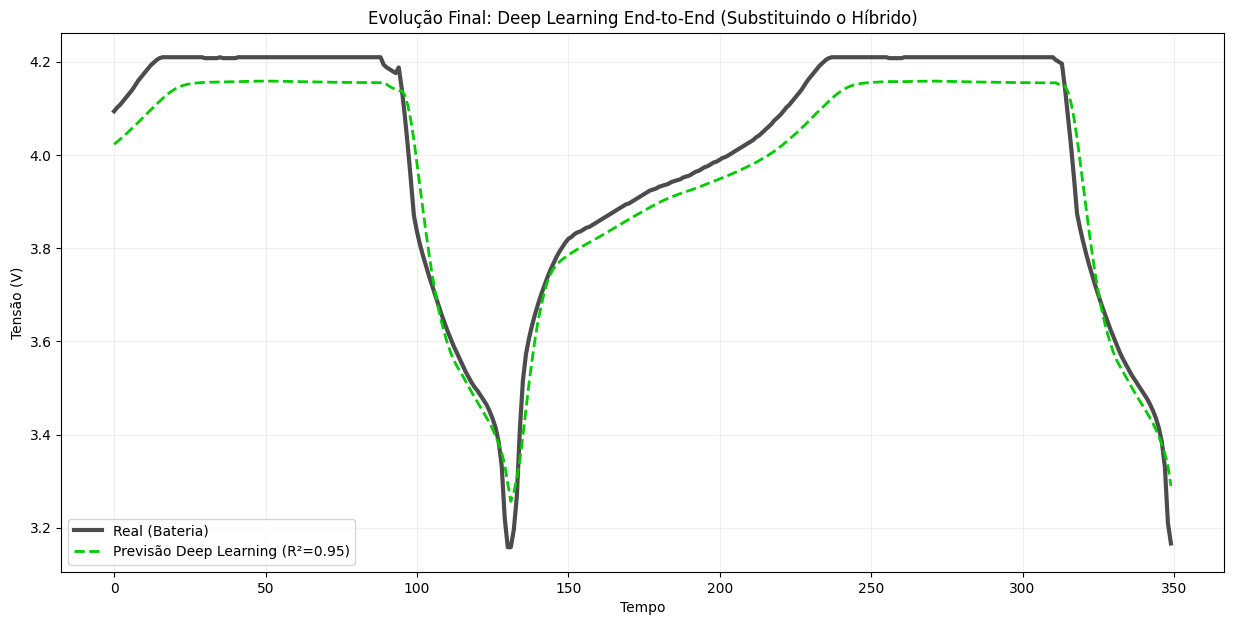

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --- 1. PREPARAÇÃO DOS DADOS ---
print("🚀 Configurando Abordagem End-to-End (Deep Learning Puro)...")
try:
    caminho = '/content/drive/MyDrive/Chantelle/multi_bateria.csv'
    df = pd.read_csv(caminho, encoding='latin-1')
    cols = ['V_measured', 'I_measured', 'T_measured']
    for c in cols: df[c] = pd.to_numeric(df[c], errors='coerce')
    df = df.dropna().reset_index(drop=True)

    # Suavização Leve (Para tirar o serrilhado do sensor)
    df['V_target'] = df['V_measured'].rolling(window=5).mean().fillna(method='bfill')

    # Feature Importante: Média da corrente
    df['I_mean'] = df['I_measured'].rolling(window=10).mean().fillna(0)
except:
    print("❌ Erro ao carregar.")

# Alvo: Tensão
target = df['V_target'].values.reshape(-1, 1)
# Features: Tensão Passada + Corrente + Temperatura
features = df[['V_target', 'I_mean', 'T_measured']].values

# Normalização
scaler = MinMaxScaler()
features_norm = scaler.fit_transform(features)
target_norm = scaler.fit_transform(target) # Normaliza alvo separado para facilitar inversão

# Divisão Temporal
n = len(features_norm)
train_size = int(n * 0.7) # Mais dados para treino (70%) para a IA aprender bem
val_size = int(n * 0.15)
test_size = n - train_size - val_size

# --- 2. CRIAÇÃO DAS JANELAS DE TEMPO (LAGS) ---
def create_dataset(dataset, target, look_back=50):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, :]) # Pega 50 passos de TODAS as variáveis
        Y.append(target[i]) # Tenta prever a Tensão do próximo passo
    return np.array(X), np.array(Y)

look_back = 50 # A IA olha os últimos ~75 minutos (50 * 90s)

# Criar Datasets
X, y = create_dataset(features_norm, target_norm, look_back)

# Dividir os arrays criados (respeitando a ordem temporal)
X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size : train_size+val_size]
y_val = y[train_size : train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

# --- 3. MODELO DEEP LEARNING (Bi-LSTM) ---
print("🧠 Treinando Rede Neural Profunda...")

model = Sequential()
# Bidirecional: Aprende a sequência de ida e volta
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(look_back, X_train.shape[2])))
model.add(Dropout(0.2))
# Segunda camada para capturar detalhes finos
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1)) # Saída: Voltagem Prevista

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Parada antecipada para evitar overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=150, batch_size=32,
                    validation_data=(X_val, y_val), callbacks=[early_stop], verbose=1)

# --- 4. PREVISÃO E GRÁFICO ---
pred_norm = model.predict(X_test)

# Desnormalizar
pred_real = scaler.inverse_transform(pred_norm)
y_test_real = scaler.inverse_transform(y_test)

# Métricas
r2 = r2_score(y_test_real, pred_real)
rmse = np.sqrt(mean_squared_error(y_test_real, pred_real))
mape = np.mean(np.abs((y_test_real - pred_real) / (y_test_real + 1e-10))) * 100

print(f"\n--- 🏁 RESULTADO END-TO-END (Deep Learning Puro) ---")
print(f"R² Score: {r2:.4f} (Quanto mais próximo de 1.0, melhor)")
print(f"MAPE:     {mape:.4f} %")
print(f"RMSE:     {rmse:.4f} V")

# Gráfico
plt.figure(figsize=(15, 7))
plt.plot(y_test_real, label='Real (Bateria)', color='black', linewidth=3, alpha=0.7)
plt.plot(pred_real, label=f'Previsão Deep Learning (R²={r2:.2f})', color='#00CC00', linewidth=2, linestyle='--') # Verde Neon

plt.title("Evolução Final: Deep Learning End-to-End (Substituindo o Híbrido)")
plt.ylabel("Tensão (V)")
plt.xlabel("Tempo")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

Previsão de Tensão de Baterias Li-Ion com Deep Learning (End-to-End)
Análise Completa: Estatística Descritiva, Testes de Hipótese e Modelagem Bi-LSTM

🚀 Iniciando análise completa...
✅ Dados carregados! Total de amostras: 2661

--- 📊 4.1 Análise Estatística e Caracterização ---

[A] Matriz de Correlação de Pearson:
            V_measured  I_measured  T_measured
V_measured    1.000000    0.409760   -0.851547
I_measured    0.409760    1.000000   -0.465429
T_measured   -0.851547   -0.465429    1.000000


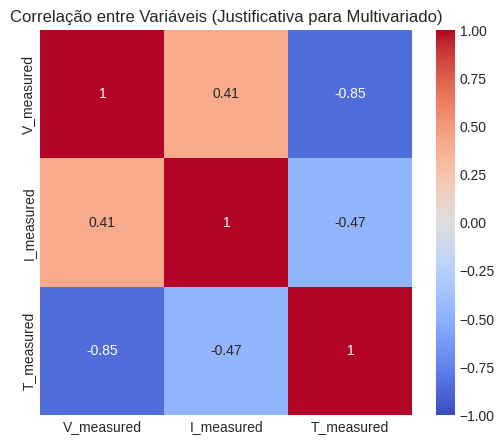


[B] Teste de Hipótese (Estacionariedade - ADF):
Estatística ADF: -5.9470
p-valor: 0.00000022
Conclusão: Série Estacionária (Rejeita H0)

[C] Decomposição Sazonal (Tendência vs Ciclo):


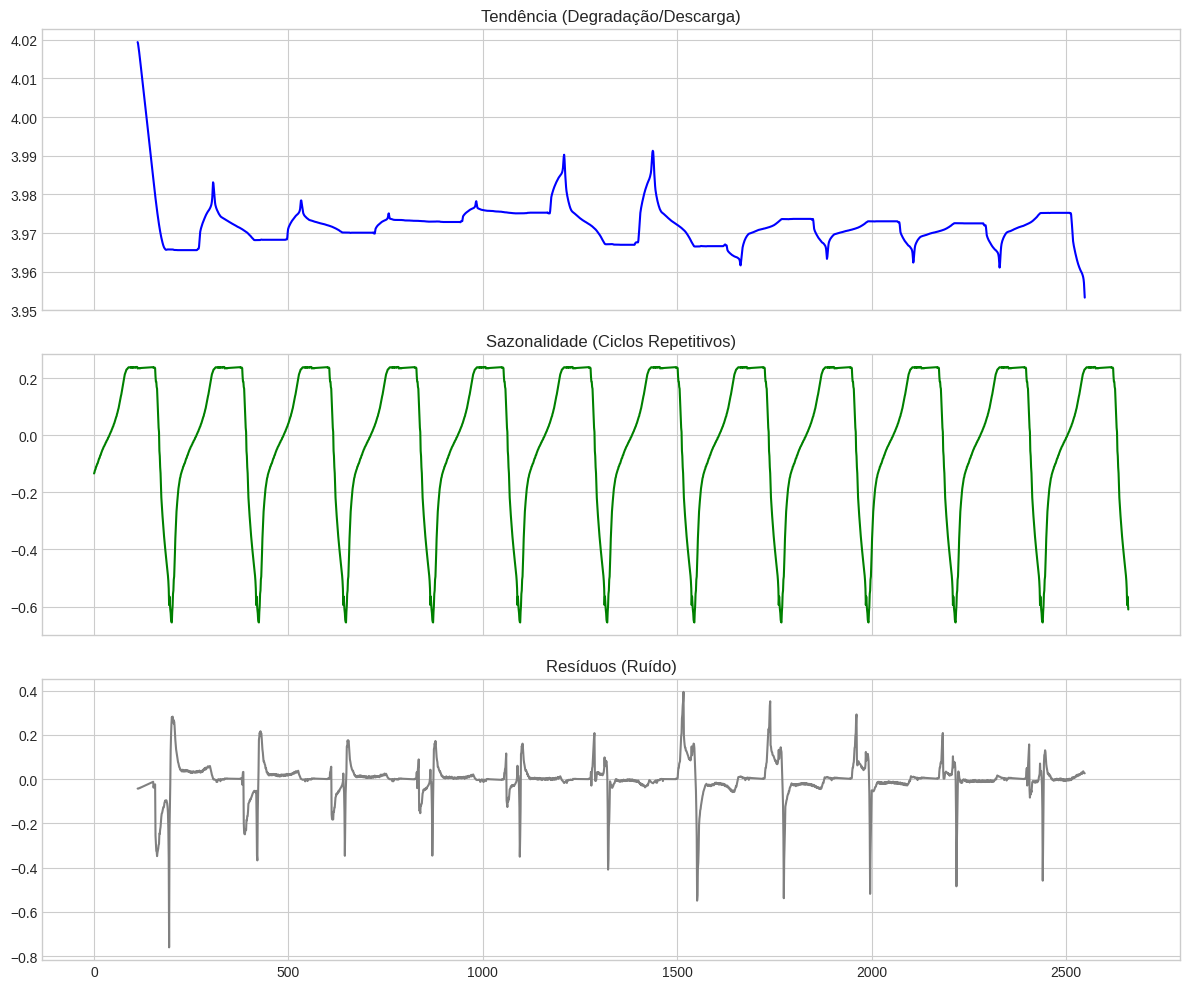


--- 🧠 4.3 Treinamento do Modelo Bi-LSTM (End-to-End) ---


/tmp/ipython-input-548926199.py:77: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['V_target'] = df['V_measured'].rolling(window=5).mean().fillna(method='bfill')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - loss: 0.2471 - val_loss: 0.0066
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0169 - val_loss: 0.0033
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0120 - val_loss: 0.0022
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0091 - val_loss: 0.0023
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.0081 - val_loss: 0.0029
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0080 - val_loss: 0.0017
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0067 - val_loss: 0.0020
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - loss: 0.0061 - val_loss: 0.0020
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 0.0054 - val_loss: 8.4308e-04
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.0059 - val_loss: 0.0058
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0052 - val_loss: 0.0018
Epoch 12/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 7

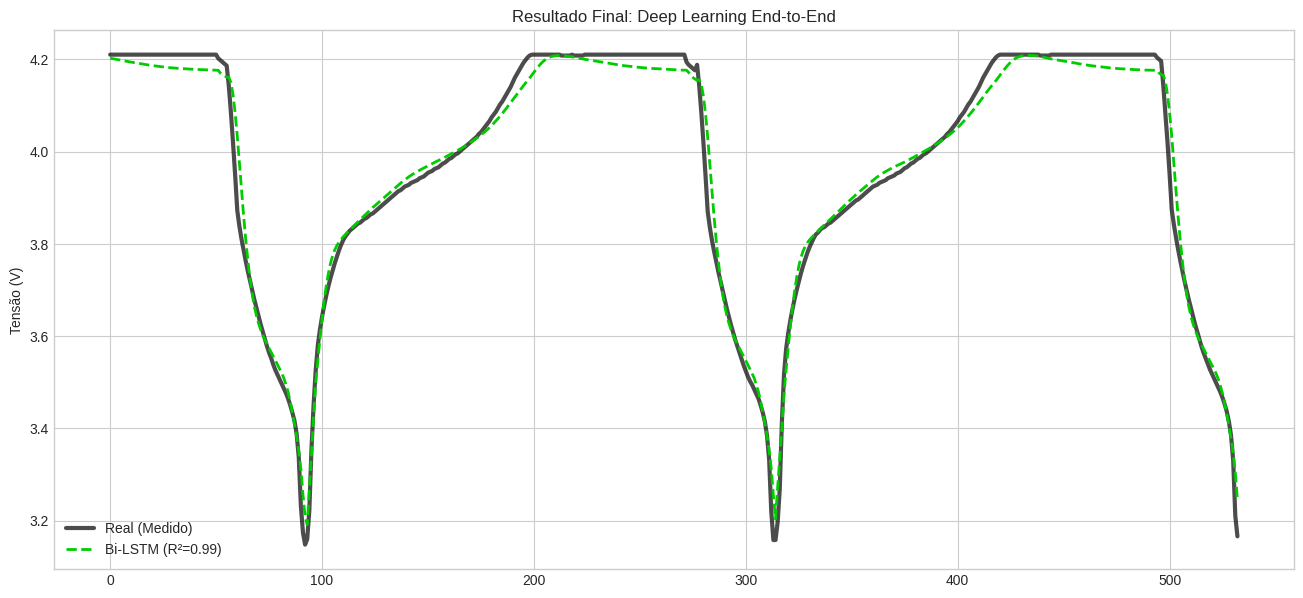

In [ ]:

# 1. Instalação e Importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Configuração visual
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# --- 2. CARREGAMENTO DOS DADOS ---
print("🚀 Iniciando análise completa...")

try:
    # AJUSTE O CAMINHO DO SEU ARQUIVO AQUI
    caminho_arquivo = '/content/drive/MyDrive/Chantelle/multi_bateria.csv'

    df = pd.read_csv(caminho_arquivo, encoding='latin-1')
    cols = ['V_measured', 'I_measured', 'T_measured']
    for c in cols: df[c] = pd.to_numeric(df[c], errors='coerce')
    df = df.dropna().reset_index(drop=True)

    print(f"✅ Dados carregados! Total de amostras: {len(df)}")

    # ==========================================================================
    # SEÇÃO 4.1: ANÁLISE ESTATÍSTICA E TESTES DE HIPÓTESE
    # ==========================================================================
    print("\n--- 📊 4.1 Análise Estatística e Caracterização ---")

    # A. Matriz de Correlação
    corr_matrix = df[['V_measured', 'I_measured', 'T_measured']].corr()
    print("\n[A] Matriz de Correlação de Pearson:")
    print(corr_matrix)

    # Plotar Correlação
    plt.figure(figsize=(6, 5))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Correlação entre Variáveis (Justificativa para Multivariado)")
    plt.show()

    # B. Teste de Estacionariedade (ADF)
    print("\n[B] Teste de Hipótese (Estacionariedade - ADF):")
    result_adf = adfuller(df['V_measured'])
    print(f"Estatística ADF: {result_adf[0]:.4f}")
    print(f"p-valor: {result_adf[1]:.8f}")
    print("Conclusão: " + ("Série Estacionária (Rejeita H0)" if result_adf[1] < 0.05 else "Série Não-Estacionária"))

    # C. Análise de Sazonalidade
    print("\n[C] Decomposição Sazonal (Tendência vs Ciclo):")
    # Period=224 foi identificado via ACF na análise anterior
    decomposition = seasonal_decompose(df['V_measured'], model='additive', period=224)

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    decomposition.trend.plot(ax=ax1, color='blue')
    ax1.set_title('Tendência (Degradação/Descarga)')
    decomposition.seasonal.plot(ax=ax2, color='green')
    ax2.set_title('Sazonalidade (Ciclos Repetitivos)')
    decomposition.resid.plot(ax=ax3, color='gray')
    ax3.set_title('Resíduos (Ruído)')
    plt.tight_layout()
    plt.show()

    # ==========================================================================
    # SEÇÃO 4.3: MODELAGEM DEEP LEARNING (END-TO-END)
    # ==========================================================================
    print("\n--- 🧠 4.3 Treinamento do Modelo Bi-LSTM (End-to-End) ---")

    # Engenharia de Features (Suavização para limpar ruído do sensor)
    df['V_target'] = df['V_measured'].rolling(window=5).mean().fillna(method='bfill')
    df['I_mean'] = df['I_measured'].rolling(window=10).mean().fillna(0)

    # Preparação dos Dados
    target = df['V_target'].values.reshape(-1, 1)
    features = df[['V_target', 'I_mean', 'T_measured']].values

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    features_norm = scaler_x.fit_transform(features)
    target_norm = scaler_y.fit_transform(target)

    # Divisão (60/20/20)
    n = len(features_norm)
    train_size = int(n * 0.6)
    val_size = int(n * 0.2)

    # Janelamento Temporal (Sliding Window)
    def create_dataset(dataset, target, look_back=50):
        X, Y = [], []
        for i in range(look_back, len(dataset)):
            X.append(dataset[i-look_back:i, :])
            Y.append(target[i])
        return np.array(X), np.array(Y)

    look_back = 50
    X, y = create_dataset(features_norm, target_norm, look_back)

    # Divisão Cronológica
    train_end = train_size - look_back
    val_end = train_size + val_size - look_back

    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]

    # Arquitetura Bi-LSTM
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=(look_back, X_train.shape[2])),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    # Treinamento
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                        validation_data=(X_val, y_val), callbacks=[early_stop], verbose=1)

    # Previsão e Métricas
    pred_norm = model.predict(X_test)
    pred_real = scaler_y.inverse_transform(pred_norm)
    y_test_real = scaler_y.inverse_transform(y_test)

    r2 = r2_score(y_test_real, pred_real)
    rmse = np.sqrt(mean_squared_error(y_test_real, pred_real))
    mape = np.mean(np.abs((y_test_real - pred_real) / (y_test_real + 1e-10))) * 100

    print("-" * 40)
    print(f"🏆 RESULTADO FINAL")
    print("-" * 40)
    print(f"R² Score: {r2:.4f}")
    print(f"MAPE:     {mape:.4f} %")
    print("-" * 40)

    # Gráfico Final
    plt.figure(figsize=(16, 7))
    plt.plot(y_test_real, label='Real (Medido)', color='black', linewidth=3, alpha=0.7)
    plt.plot(pred_real, label=f'Bi-LSTM (R²={r2:.2f})', color='#00CC00', linewidth=2, linestyle='--')
    plt.title("Resultado Final: Deep Learning End-to-End")
    plt.ylabel("Tensão (V)")
    plt.legend()
    plt.show()

except Exception as e:
    print(f"❌ Erro: {e}")

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# As variáveis y_test_real e pred_real já estão disponíveis do último treinamento do modelo.
# y_test_real: Valores reais da tensão (desnormalizados)
# pred_real: Valores previstos da tensão (desnormalizados)

print("\n--- Cálculo das Métricas de Desempenho ---")

# 1. MSE (Mean Squared Error)
mse = mean_squared_error(y_test_real, pred_real)
print(f"MSE (Mean Squared Error): {mse:.6f}")

# 2. RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)
print(f"RMSE (Root Mean Squared Error): {rmse:.6f}")

# 3. MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test_real, pred_real)
print(f"MAE (Mean Absolute Error): {mae:.6f}")

# 4. MAPE (Mean Absolute Percentage Error)
# Evita divisão por zero adicionando um pequeno epsilon
mape = np.mean(np.abs((y_test_real - pred_real) / (y_test_real + 1e-10))) * 100
print(f"MAPE (Mean Absolute Percentage Error): {mape:.4f} %")

# 5. POCID (Percentage of Correct Increasing Direction)
def calculate_pocid(y_true, y_pred):
    true_direction = np.sign(np.diff(y_true, axis=0))
    pred_direction = np.sign(np.diff(y_pred, axis=0))
    # Conta onde as direções correspondem e não são zero (ou seja, houve mudança)
    correct_directions = (true_direction == pred_direction) & (true_direction != 0)
    if len(correct_directions) == 0: # Para evitar divisão por zero se não houver mudanças
        return 0.0
    pocid = np.sum(correct_directions) / np.sum(true_direction != 0) * 100
    return pocid

pocid = calculate_pocid(y_test_real, pred_real)
print(f"POCID (Percentage of Correct Increasing Direction): {pocid:.2f} %")

# 6. ARV (Average Relative Variance) ou Normalized MSE
# Uma definição comum é MSE dividido pela variância dos dados reais
def calculate_arv(y_true, y_pred):
    mse_val = mean_squared_error(y_true, y_pred)
    variance_y_true = np.var(y_true)
    if variance_y_true == 0: # Evitar divisão por zero se os valores reais não variarem
        return np.inf # ou algum outro valor que indique indefinição
    arv = mse_val / variance_y_true
    return arv

arv = calculate_arv(y_test_real, pred_real)
print(f"ARV (Average Relative Variance): {arv:.6f}")



--- Cálculo das Métricas de Desempenho ---
MSE (Mean Squared Error): 0.001088
RMSE (Root Mean Squared Error): 0.032984
MAE (Mean Absolute Error): 0.023129
MAPE (Mean Absolute Percentage Error): 0.5885 %
POCID (Percentage of Correct Increasing Direction): 97.67 %
ARV (Average Relative Variance): 0.014762
